<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Linear Classification</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

## Regularization

Question:
  * Why do we use regularization?
  * What kind of regularization do you know?

L2 - reg
$$
L(X, y, w) = l(X, y, w) + \lambda  \langle w, w \rangle
$$

L1 - reg
$$
L(X, y, w) = l(X,y, w) + \lambda |w|
$$

Elastic net
$$
L(X, y, w) = l(X, y, w) + \lambda_1  \langle w, w \rangle + \lambda_2 |w|
$$

# Linear classification

### Sigmoid function

$$
\sigma(x) = \frac{1}{1 + \exp(-\langle w, x \rangle)}
$$

Or if we use intercept
$$
\sigma(x) = \frac{1}{1 + \exp(-\langle w, x \rangle - w_0)}
$$

We assume that 
$$
\sigma(x) = P(y = 1 | x, w)
$$

Question 
  * 1 - $\sigma(x) =$ ?
  * $\sigma'(x) =$ ?

And we maximize likelihood with log-loss minimization

if $y_i \in \{0, 1\}$
$$
logloss = \frac{1}{N}\sum_{i=1}^n\left[y_i \log(1 + \exp(-\langle w, x \rangle) + (1 -y_i) \log(1 + \exp(\langle w, x \rangle))\right]
$$

if $y_i \in \{-1, 1\}$
$$
logloss = \frac{1}{N}\sum_{i=1}^n\left[\log(1 + \exp(-\langle w, x \rangle \cdot y_i)\right]
$$

## Toy example

Generate data and apply logistic regression

In [3]:
#generate two linear separated samples
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [2, 2],
          np.random.randn(20, 2) + [-2, -2]]
y = [-1] * 20 + [1] * 20

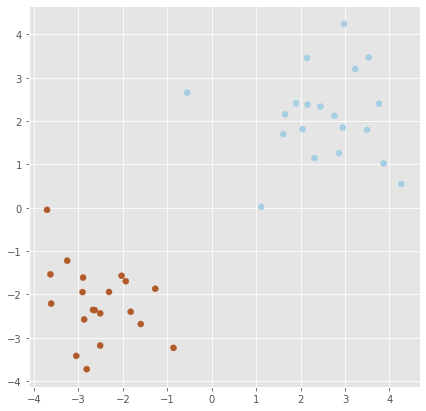

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

In [13]:
class SimpleLogisticRegression:
    def __init__(self, C = 1.0, fit_intercept = True, penalty = 'l2', max_iter = 5000):
        self.C = C
        self.fit_intercept = fit_intercept
        self.penalty = penalty
        self.max_iter = max_iter
    
    
    def fit(self, X, y):        
        #zero initialization
        self.coef_ = np.zeros(X.shape[1])
        self.intercept_ = 0.0
        
        #run grad descent
        self.qual_ = self.grad_descent(X, y, 0.05)
        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(X.dot(self.coef_) + self.intercept_)),\
                         1 / (1 + np.exp(-X.dot(self.coef_) - self.intercept_))])
    
    def predict(self, X):
        predict = (self.predict_proba(X)[1, :] > 0.5).astype(int)
        
        #transform 0 to -1
        predict[predict == 0] = -1
        
        return predict
    
    def decision_function(self, X):
        return X.dot(self.coef_) + self.intercept_

    #labels of classes {1, -1}
    def loss(self, X, y):
        loss = np.mean(np.log(1 + np.exp((-X.dot(self.coef_) + self.intercept_) * y)))
        if self.penalty == 'l2':
            reg = np.sum(self.coef_ ** 2)
            if self.fit_intercept:
                reg += self.intercept_ ** 2
        elif self.penalty == 'l1':
            reg = np.sum(np.abs(self.coef_))
            if self.fit_intercept:
                reg += np.abs(self.intercept_)
        else:
            raise NotImplementedError
        
        return loss + reg / (self.C * X.shape[0])
    
    def grad_descent(self, X, y, eta ):
        qual = np.zeros(self.max_iter)
        
        for iterations in range(self.max_iter):
            #calculate gradient
            decision_function = -(X.dot(self.coef_) + self.intercept_)
            grad_coef = -np.exp(decision_function * y) / (1 + np.exp(decision_function * y))
            grad_coef *= y
            
            if isinstance(X, np.ndarray):
                mean_grad = np.mean(X.T * grad_coef, axis = 1)
            elif isinstance(X, scipy.sparse.csr.csr_matrix):
                mean_grad = np.array(np.mean(X.T.multiply(grad_coef), axis = 1)[:, 0]).reshape(-1)
            else:
                raise NotImplementedError

            w = np.copy(self.coef_)
            self.coef_ -= eta * mean_grad
            
            if self.fit_intercept:
                w_0 = self.intercept_
                self.intercept_ -= eta * np.mean(grad_coef)
    
            #add penalty
            if self.penalty == 'l2':
                self.coef_ -= 2 * eta * w / (self.C * X.shape[0])
                if self.fit_intercept:
                    self.intercept_ -= 2 * eta * w_0 / (self.C * X.shape[0])
            elif self.penalty == 'l1':
                self.coef_ -= eta * np.sign(w) / (self.C * X.shape[0])
                if self.fit_intercept:
                    self.intercept_ -= eta * np.sign(w_0) / (self.C * X.shape[0])
            else:
                raise NotImplementedError
            qual[iterations] = self.loss(X, y)

        return qual

Fit logistic regression and plot desicion boundary

In [14]:
model = SimpleLogisticRegression(C=1.0, 
                           fit_intercept=True, 
                           penalty='l2')
model.fit(X, y)

In [15]:
print('w_0 = %f' % model.intercept_)
print('w_1, w_2 = ', model.coef_)

w_0 = -0.113541
w_1, w_2 =  [-0.91292259 -0.8538947 ]


In [16]:
y_hat = model.predict(X)
y_hat

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [17]:
y_hat_proba = model.predict_proba(X)
y_hat_proba[:20, :]

array([[0.99631323, 0.99842854, 0.98920287, 0.98769405, 0.98022867,
        0.99344189, 0.98840871, 0.98709704, 0.99212355, 0.96097233,
        0.86699141, 0.97817449, 0.98876487, 0.97150491, 0.99816919,
        0.98388157, 0.75865225, 0.96961838, 0.99697267, 0.95414983,
        0.00372155, 0.03516082, 0.01393339, 0.01984218, 0.00621154,
        0.01970056, 0.0074316 , 0.04393683, 0.04306236, 0.01326958,
        0.01285584, 0.00355267, 0.02656606, 0.01084474, 0.01471548,
        0.06633797, 0.03123993, 0.02564213, 0.00893025, 0.0251713 ],
       [0.00368677, 0.00157146, 0.01079713, 0.01230595, 0.01977133,
        0.00655811, 0.01159129, 0.01290296, 0.00787645, 0.03902767,
        0.13300859, 0.02182551, 0.01123513, 0.02849509, 0.00183081,
        0.01611843, 0.24134775, 0.03038162, 0.00302733, 0.04585017,
        0.99627845, 0.96483918, 0.98606661, 0.98015782, 0.99378846,
        0.98029944, 0.9925684 , 0.95606317, 0.95693764, 0.98673042,
        0.98714416, 0.99644733, 0.97343394, 0.9

In [18]:
dec_func = model.decision_function(X)
dec_func

array([-5.59931133, -6.45417481, -4.51761944, -4.38529003, -3.90355303,
       -5.02047304, -4.44584215, -4.33731148, -4.83597095, -3.20367472,
       -1.87461534, -3.80260852, -4.47741109, -3.52911465, -6.30116241,
       -4.11154194, -1.14530469, -3.46306466, -5.79704191, -3.03544185,
        5.58988669,  3.31202904,  4.25943552,  3.8999035 ,  5.07511481,
        3.90721087,  4.89455432,  3.08007109,  3.10108898,  4.30892294,
        4.34101808,  5.63649639,  3.60119549,  4.51317079,  4.20403048,
        2.64435214,  3.43431981,  3.63754214,  4.70934026,  3.65655726])

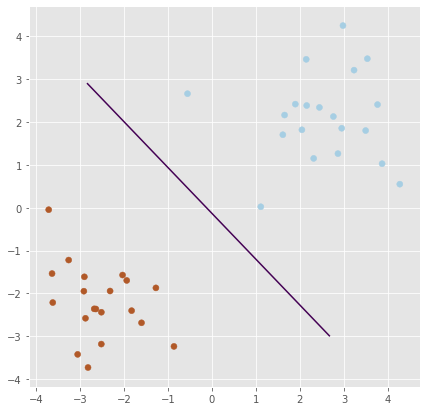

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
x0, x1 = np.meshgrid(np.arange(-3, 3, 0.1),
                       np.arange(-3, 3, 0.1))
xx0, xx1 = x0.ravel(), x1.ravel()

X_grid = np.c_[xx0, xx1, ]

y_hat = model.decision_function(X_grid)
y_hat = y_hat.reshape(x0.shape)

plt.contour(x0, x1, y_hat, levels=[0])


ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

Let's watch how change loss by iteration

Text(0, 0.5, 'logarithm of log-loss with l2')

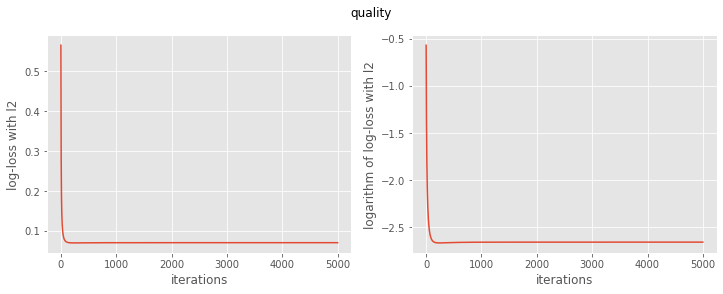

In [20]:
qual = model.qual_
x = np.arange(0, len(qual))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[12, 4])
plt.suptitle('quality')
ax1.plot(x, qual)
ax2.plot(x, np.log(qual))
ax1.set_xlabel('iterations')
ax2.set_xlabel('iterations')
ax1.set_ylabel('log-loss with l2')
ax2.set_ylabel('logarithm of log-loss with l2')

## How to make non-linear decision boundary?

Consider "bublic" dataset

In [12]:
from sklearn.datasets import make_circles

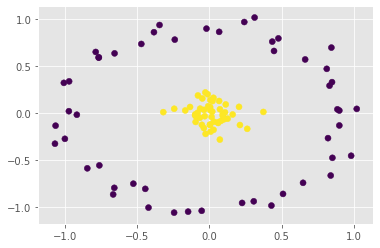

In [13]:
X, y = make_circles(n_samples=100, shuffle=True,
                    noise = 0.1,
                    factor=0.1)
y[y == 0] = -1

plt.scatter(X[:, 0],
            X[:, 1],
            c=y)

It is clear that classes cannot be separated via line.

In [14]:
X_new = np.c_[X[:,0], X[:,1],]
model = SimpleLogisticRegression(C=100000, 
                           fit_intercept=True)
model.fit(X_new, y)

In [15]:
# Error rate
y_hat = model.predict(X_new)
'Accuracy = {}'.format((y == y_hat).mean())

'Accuracy = 0.54'

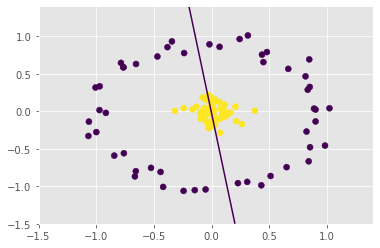

In [16]:
# Plot desicion border

x0, x1 = np.meshgrid(np.arange(-1.5, 1.5, 0.1),
                       np.arange(-1.5, 1.5, 0.1))
xx0, xx1 = x0.ravel(), x1.ravel()

X_grid = np.c_[xx0, xx1, ]

y_hat = model.decision_function(X_grid)
y_hat = y_hat.reshape(x0.shape)

plt.contour(x0, x1, y_hat, levels=[0])
plt.scatter(X[:,0], 
            X[:, 1], 
            c=y)

So what we do is we should add nonliear feature to our model and then project decision boundary on to intial feature space

What feature should we use?

In [17]:
X_new = np.c_[X[:,0], X[:,1], X[:, 0]**2+X[:, 1]**2]
model = SimpleLogisticRegression(C = 100000, 
                           fit_intercept=True)
model.fit(X_new, y)

In [18]:
# Error rate
y_hat = model.predict(X_new)
'Accuracy = {}'.format((y == y_hat).mean())

'Accuracy = 1.0'

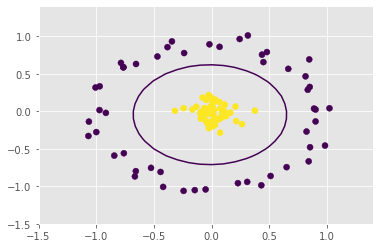

In [19]:
# Plot desicion border

x0, x1 = np.meshgrid(np.arange(-1.5, 1.5, 0.1),
                       np.arange(-1.5, 1.5, 0.1))

xx0, xx1 = x0.ravel(), x1.ravel()

X_grid = np.c_[xx0, xx1, xx0**2 + xx1**2]

y_hat = model.decision_function(X_grid)
y_hat = y_hat.reshape(x0.shape)

plt.contour(x0, x1, y_hat, levels=[0])
plt.scatter(X[:,0], 
            X[:, 1], 
            c=y)

## L1 - reg

L1-reg work like feature selection

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
X_new = np.c_[X[:,0], X[:,1], X[:, 0] ** 2 + X[:, 1] ** 2]
model = SimpleLogisticRegression(C=1, 
                           fit_intercept=True,
                           penalty = 'l1')
model.fit(X_new, y)

In [22]:
model.coef_, model.intercept_

(array([ 1.87710719e-04, -4.07730417e-04, -6.85297664e+00]),
 2.8825991341636663)

### Coef near useless features is very small

Question for students: Why l1 work like feature-selection?

<center><img src="img/reg.png"></center>

## Real example - sentiment analysis

Load text files amazon_cells_labelled.txt


File format:
Review \t class label \n


### Task
1. Load files and set target features and review in different variables
2. Fit logistic regression to it. Consider text feature preprocessing
3. Output the most valuable coefficients and analyze them

In [23]:
##load file
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s05-logistic-regresion/sentiment/amazon_cells_labelled.txt', #'sentiment/amazon_cells_labelled.txt', 
                 sep='\t', header=None, 
                 names=['review', 'class'])

df.head()

,review,class
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [24]:
#use CountVectorizer from sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
vect = CountVectorizer(stop_words='english', #which word don't calculate
                       max_df=0.95, #max document frequency of the word
                       min_df=5, #remove word which appear less than 5 documents
                       ngram_range=(1,1),
                       analyzer='word')

In [26]:
texts = df.review.values

In [27]:
texts[:10]

array(['So there is no way for me to plug it in here in the US unless I go by a converter.',
       'Good case, Excellent value.', 'Great for the jawbone.',
       'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
       'The mic is great.',
       'I have to jiggle the plug to get it to line up right to get decent volume.',
       'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.',
       'If you are Razr owner...you must have this!',
       'Needless to say, I wasted my money.',
       'What a waste of money and time!.'], dtype=object)

In [28]:
#calulate word frequency for every document
X = vect.fit_transform(texts)

In [29]:
#get name of words
vect.get_feature_names()

['amazon',
 'arrived',
 'audio',
 'awesome',
 'bad',
 'battery',
 'belt',
 'best',
 'better',
 'big',
 'black',
 'bluetooth',
 'bought',
 'broke',
 'buttons',
 'buy',
 'cable',
 'calls',
 'came',
 'camera',
 'car',
 'case',
 'cases',
 'cell',
 'charge',
 'charger',
 'charging',
 'charm',
 'cheap',
 'clarity',
 'clear',
 'color',
 'comfortable',
 'company',
 'completely',
 'connection',
 'cool',
 'couldn',
 'couple',
 'crap',
 'customer',
 'days',
 'definitely',
 'design',
 'device',
 'did',
 'didn',
 'different',
 'difficult',
 'disappointed',
 'disappointing',
 'disappointment',
 'does',
 'doesn',
 'don',
 'dropped',
 'ear',
 'ears',
 'easily',
 'easy',
 'end',
 'especially',
 'excellent',
 'expect',
 'far',
 'feature',
 'feels',
 'fine',
 'fit',
 'fits',
 'free',
 'gets',
 'going',
 'good',
 'got',
 'great',
 'hands',
 'happy',
 'hard',
 'having',
 'headphones',
 'headset',
 'headsets',
 'hear',
 'helpful',
 'high',
 'highly',
 'hold',
 'horrible',
 'hours',
 'important',
 'impressed

In [30]:
X = vect.fit_transform(texts)
y = df.loc[:, 'class'].values
y[y == 0] = -1

In [31]:
#train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [32]:
model = SimpleLogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)

Text(0, 0.5, 'log-loss with l2')

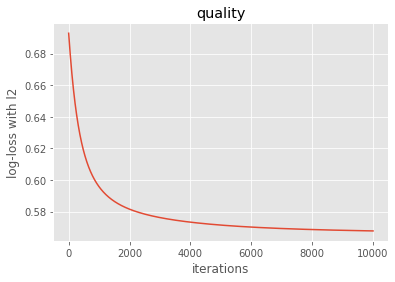

In [33]:
#plot of the quality
qual = model.qual_
x = np.arange(0, len(qual))
plt.title('quality')
plt.plot(x, qual)
plt.xlabel('iterations')
plt.ylabel('log-loss with l2')

In [34]:
y_hat = model.predict(X_train)
print('Train accuracy = {}'.format((y_train == y_hat).mean()))

y_hat = model.predict(X_test)
print('Test accuracy = {}'.format((y_test == y_hat).mean()))

Train accuracy = 0.84375
Test accuracy = 0.78


In [35]:
coefs = model.coef_
words = vect.get_feature_names()

In [36]:
#sort word by it coefs (word with small coef first, with large coef last)
weights = pd.Series(index=words, data=coefs)
weights.sort_values()

poor           -1.103020
bad            -0.959707
worst          -0.904254
disappointed   -0.774502
horrible       -0.710753
                  ...   
love            1.319478
excellent       1.486672
good            1.520940
works           1.669133
great           2.095157
Length: 203, dtype: float64

Let's evaluate our model on another text corpus

In [37]:
##load file
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s05-logistic-regresion/sentiment/imdb_labelled.txt', #'sentiment/imdb_labelled.txt', 
                 sep='\t', header=None, 
                 names=['review', 'class'])

df.head()

,review,class
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [38]:
texts = df.review.values
X_test = vect.transform(texts)
y_test = df.loc[:, 'class'].values
y_test[y_test == 0] = -1
y_hat = model.predict(X_test)
'Accuracy = {}'.format((y_test == y_hat).mean())

'Accuracy = 0.6096256684491979'

### Not so bad!